In [1]:
!pip install numpy pandas scikit-fuzzy matplotlib requests

In [204]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [205]:
#load the cleaned dataset

df = sns.load_dataset("tips")

percentage = 0.3 
df[:int(len(df) * percentage)]

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
68,20.23,2.01,Male,No,Sat,Dinner,2
69,15.01,2.09,Male,Yes,Sat,Dinner,2
70,12.02,1.97,Male,No,Sat,Dinner,2
71,17.07,3.00,Female,No,Sat,Dinner,3


In [206]:
df["tip_percent"] = (df["tip"] / df["total_bill"]) * 100
percentage = 0.3 
df[:int(len(df) * percentage)]

,total_bill,tip,sex,smoker,day,time,size,tip_percent
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765
...,...,...,...,...,...,...,...,...
68,20.23,2.01,Male,No,Sat,Dinner,2,9.935739
69,15.01,2.09,Male,Yes,Sat,Dinner,2,13.924051
70,12.02,1.97,Male,No,Sat,Dinner,2,16.389351
71,17.07,3.00,Female,No,Sat,Dinner,3,17.574692


In [207]:
tip_percent = ctrl.Antecedent(np.arange(0, 76, 1), 'tip_percent')  # 0 - 75
size = ctrl.Antecedent(np.arange(1, 7, 1), 'size')                 # 1 - 6
customer_satisfaction = ctrl.Consequent(np.arange(0, 11, 1), 'customer_satisfaction')

In [208]:
# Membership functions untuk tip_percent
tip_percent['low'] = fuzz.trimf(tip_percent.universe, [0, 0, 15])
tip_percent['average'] = fuzz.trimf(tip_percent.universe, [10, 20, 35])
tip_percent['high'] = fuzz.trimf(tip_percent.universe, [30, 50, 75])

# Membership functions untuk size
size['small'] = fuzz.trimf(size.universe, [1, 1, 3])
size['medium'] = fuzz.trimf(size.universe, [2, 4, 6])
size['large'] = fuzz.trimf(size.universe, [4, 6, 6])

# Membership functions untuk satisfaction
customer_satisfaction['low'] = fuzz.trimf(customer_satisfaction.universe, [0, 0, 4])
customer_satisfaction['medium'] = fuzz.trimf(customer_satisfaction.universe, [3, 5, 7])
customer_satisfaction['high'] = fuzz.trimf(customer_satisfaction.universe, [6, 10, 10])

/opt/anaconda3/envs/ai_env/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


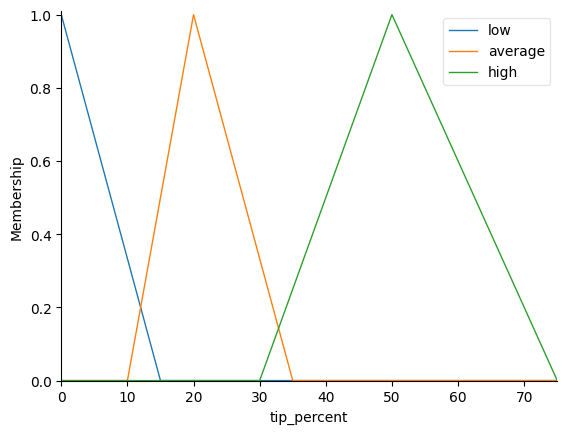

In [209]:
tip_percent.view()
plt.show()

/opt/anaconda3/envs/ai_env/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


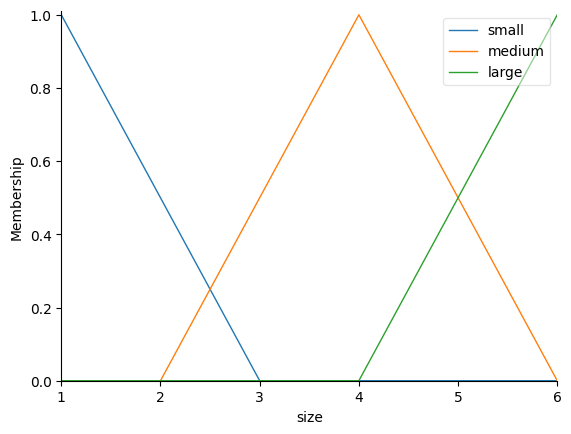

In [210]:
size.view()
plt.show()


/opt/anaconda3/envs/ai_env/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


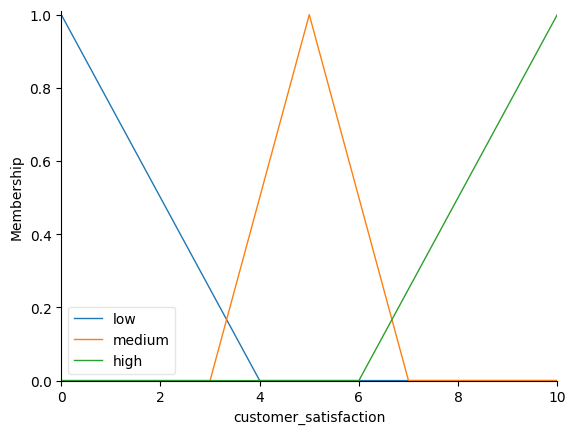

In [211]:
customer_satisfaction.view()
plt.show()

In [212]:
rule1 = ctrl.Rule(tip_percent['low'] & size['small'], customer_satisfaction['low'])
rule2 = ctrl.Rule(tip_percent['low'] & size['medium'], customer_satisfaction['low'])
rule3 = ctrl.Rule(tip_percent['low'] & size['large'], customer_satisfaction['low'])

rule4 = ctrl.Rule(tip_percent['average'] & size['small'], customer_satisfaction['medium'])
rule5 = ctrl.Rule(tip_percent['average'] & size['medium'], customer_satisfaction['medium'])
rule6 = ctrl.Rule(tip_percent['average'] & size['large'], customer_satisfaction['medium'])

rule7 = ctrl.Rule(tip_percent['high'] & size['small'], customer_satisfaction['high'])
rule8 = ctrl.Rule(tip_percent['high'] & size['medium'], customer_satisfaction['high'])
rule9 = ctrl.Rule(tip_percent['high'] & size['large'], customer_satisfaction['high'])



In [213]:
satisfaction_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4, rule5,
    rule6, rule7, rule8, rule9
])
satisfaction_sim = ctrl.ControlSystemSimulation(satisfaction_ctrl)


In [214]:
def compute_customer_satisfaction(row):
    satisfaction_simulation = ctrl.ControlSystemSimulation(satisfaction_ctrl)

    tip_percent_value = None
    size_value = None

    try:
        tip_percent_value = row['tip_percent']
        size_value = row['size']   # gunakan kolom 'size' dari dataset

        tip_percent_value = np.clip(tip_percent_value, tip_percent.universe[0], tip_percent.universe[-1])
        size_value = np.clip(size_value, size.universe[0], size.universe[-1])

        satisfaction_simulation.input['tip_percent'] = tip_percent_value
        satisfaction_simulation.input['size'] = size_value

        satisfaction_simulation.compute()

        return satisfaction_simulation.output['customer_satisfaction']

    except Exception as ex:
        print(f"Error computing for row {row.name}: {ex}")
        print(f"Inputs: tip_percent={tip_percent_value}, size={size_value}")
        return np.nan

df['customer_satisfaction'] = df.apply(compute_customer_satisfaction, axis=1)

print(df)


     total_bill   tip     sex smoker   day    time  size  tip_percent  \
0         16.99  1.01  Female     No   Sun  Dinner     2     5.944673   
1         10.34  1.66    Male     No   Sun  Dinner     3    16.054159   
2         21.01  3.50    Male     No   Sun  Dinner     3    16.658734   
3         23.68  3.31    Male     No   Sun  Dinner     2    13.978041   
4         24.59  3.61  Female     No   Sun  Dinner     4    14.680765   
..          ...   ...     ...    ...   ...     ...   ...          ...   
239       29.03  5.92    Male     No   Sat  Dinner     3    20.392697   
240       27.18  2.00  Female    Yes   Sat  Dinner     2     7.358352   
241       22.67  2.00    Male    Yes   Sat  Dinner     2     8.822232   
242       17.82  1.75    Male     No   Sat  Dinner     2     9.820426   
243       18.78  3.00  Female     No  Thur  Dinner     2    15.974441   

     customer_satisfaction  
0                 1.555556  
1                 5.000000  
2                 5.000000  
3      

In [215]:
print("Tip percent range:", data["tip_percent"].min(), "→", data["tip_percent"].max())
print("Size range:", data["size"].min(), "→", data["size"].max())

Tip percent range: 3.563813585135547 → 71.0344827586207
Size range: 1 → 6


In [216]:
def classify_satisfaction(score):
    if score < 4:
        return "Low"
    elif score < 7:
        return "Medium"
    else:
        return "High"

df['customer_satisfaction_category'] = df['customer_satisfaction'].apply(classify_satisfaction)

print(df)

     total_bill   tip     sex smoker   day    time  size  tip_percent  \
0         16.99  1.01  Female     No   Sun  Dinner     2     5.944673   
1         10.34  1.66    Male     No   Sun  Dinner     3    16.054159   
2         21.01  3.50    Male     No   Sun  Dinner     3    16.658734   
3         23.68  3.31    Male     No   Sun  Dinner     2    13.978041   
4         24.59  3.61  Female     No   Sun  Dinner     4    14.680765   
..          ...   ...     ...    ...   ...     ...   ...          ...   
239       29.03  5.92    Male     No   Sat  Dinner     3    20.392697   
240       27.18  2.00  Female    Yes   Sat  Dinner     2     7.358352   
241       22.67  2.00    Male    Yes   Sat  Dinner     2     8.822232   
242       17.82  1.75    Male     No   Sat  Dinner     2     9.820426   
243       18.78  3.00  Female     No  Thur  Dinner     2    15.974441   

     customer_satisfaction customer_satisfaction_category  
0                 1.555556                            Low  
1  

In [217]:
top_customers = df.sort_values(by='customer_satisfaction', ascending=False).head(10)

top_customers.to_csv("./top-customers.csv", index=False)

top_customers[['tip_percent', 'size', 
               'customer_satisfaction', 'customer_satisfaction_category']]

,tip_percent,size,customer_satisfaction,customer_satisfaction_category
178,41.666667,2,8.444444,High
172,71.034483,2,8.154066,High
67,32.573290,1,6.388162,Medium
212,18.621974,4,5.000000,Medium
5,18.623962,4,5.000000,Medium
116,16.939526,4,5.000000,Medium
211,19.930475,4,5.000000,Medium
44,18.421053,4,5.000000,Medium
47,18.518519,4,5.000000,Medium
54,16.979656,4,5.000000,Medium


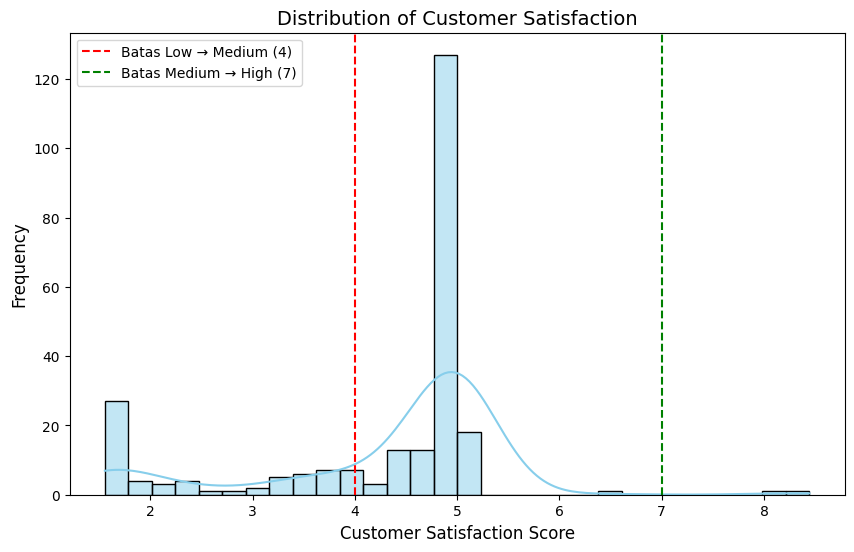

In [218]:
plt.figure(figsize=(10,6))
sns.histplot(df['customer_satisfaction'], kde=True, bins=30, color='skyblue')

# Tambah garis batas kategori
plt.axvline(4, color='red', linestyle='--', label='Batas Low → Medium (4)')
plt.axvline(7, color='green', linestyle='--', label='Batas Medium → High (7)')

# Labeling
plt.title("Distribution of Customer Satisfaction", fontsize=14)
plt.xlabel("Customer Satisfaction Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()